In [25]:
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

In [26]:
df_students = pd.read_csv('/Users/althaaframadhan/Documents/Skripsi/Penelitian/Transformation/students_ntc.csv')

In [27]:
print(df_students.head())
print(df_students.info())

      Age  Gender Academic_Level     Country Avg_Daily_Usage_Hours  \
0  Medium  Female  Undergraduate      France                   Low   
1     Low  Female  Undergraduate  Azerbaijan                Medium   
2    High  Female       Graduate  Kyrgyzstan                   Low   
3     Low  Female  Undergraduate  Bangladesh                   Low   
4    High    Male       Graduate     Germany                   Low   

  Most_Used_Platform Affects_Academic_Performance Sleep_Hours_Per_Night  \
0          Instagram                           No                  High   
1             TikTok                          Yes                   Low   
2           Facebook                           No                Medium   
3          Instagram                          Yes                  High   
4           Facebook                           No                  High   

  Mental_Health_Score Conflicts_Over_Social_Media Addicted_Score  
0                High                      Medium            

In [28]:
# ============================================
# Cell 2 - Preprocessing (fungsi reusable)
# ============================================
def preprocess_to_categorical(df_students, drop_cols=None, fillna='NA', convert_all_str=True, verbose=True):
    
    dfc = df_students.copy()
    if drop_cols:
        for c in drop_cols:
            if c in dfc.columns:
                dfc = dfc.drop(columns=c)
    # fill NA
    dfc = dfc.fillna(fillna)
    if convert_all_str:
        for c in dfc.columns:
            dfc[c] = dfc[c].astype(str)
    # fit ordinal encoder on full table
    enc = OrdinalEncoder(dtype=np.int32)
    enc.fit(dfc.values)
    df_enc = pd.DataFrame(enc.transform(dfc.values).astype(int),
                          columns=dfc.columns, index=dfc.index)

    if verbose:
        print("preprocess_to_categorical -> selesai.")
        print(f"  - df_cat shape: {dfc.shape}")
        print(f"  - df_enc shape: {df_enc.shape}")
        print(f"  - kolom: {list(dfc.columns)}")

    return dfc, df_enc, enc

dfc, df_enc, enc = preprocess_to_categorical(df_students, drop_cols=['student_id'], fillna='NA', convert_all_str=True, verbose=True)


preprocess_to_categorical -> selesai.
  - df_cat shape: (200, 11)
  - df_enc shape: (200, 11)
  - kolom: ['Age', 'Gender', 'Academic_Level', 'Country', 'Avg_Daily_Usage_Hours', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score']


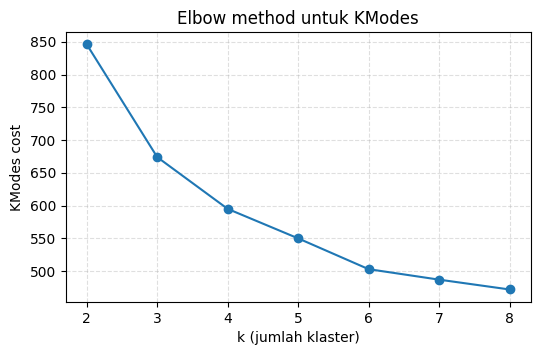

find_k_elbow_kmodes -> selesai.
  - ks tested: [2, 3, 4, 5, 6, 7, 8]
  - costs: [846. 674. 595. 550. 503. 487. 472.]


In [29]:
# =============================================
# Cell 3 - Fungsi mencari k (Elbow) dan keluaran jelas
# =============================================
def find_k_elbow_kmodes(df_enc, k_min=2, k_max=8, init='random', n_init=10, random_state=42, plot=True, verbose=True):
    
    ks = list(range(k_min, k_max+1))
    costs = []
    models = []
    X = df_enc.values
    for k in ks:
        km = KModes(n_clusters=k, init=init, n_init=n_init, random_state=random_state, verbose=0)
        km.fit(X)
        costs.append(km.cost_)
        models.append(km)
    if plot:
        plt.figure(figsize=(6,3.5))
        plt.plot(ks, costs, marker='o')
        plt.xlabel('k (jumlah klaster)')
        plt.ylabel('KModes cost')
        plt.title('Elbow method untuk KModes')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()
    if verbose:
        print("find_k_elbow_kmodes -> selesai.")
        print(f"  - ks tested: {ks}")
        print(f"  - costs: {np.round(costs, 2)}")

    return {'ks': ks, 'costs': costs, 'models': models}

elbow_results = find_k_elbow_kmodes(df_enc, k_min=2, k_max=8, plot=True, verbose=True)


In [30]:
costs = np.array(elbow_results['costs'])
if len(costs) >= 2:
    diffs = -np.diff(costs)  # positive jika turun
    k_best_idx = np.argmax(diffs) + 1  # +1 karena diff offset
    k_best = elbow_results['ks'][k_best_idx]
else:
    k_best = elbow_results['ks'][0]
print(f"K_best {k_best}")

K_best 3


In [31]:
def train_kmodes(df_enc_or_array, k = k_best, init="random", n_init=10, random_state=42, verbose=True):
    
    # Pastikan input berupa numpy array
    X = df_enc_or_array.values if hasattr(df_enc_or_array, "values") else np.array(df_enc_or_array)

    km = KModes( n_clusters=k, init=init, n_init=n_init, random_state=random_state, verbose=0)
    labels = km.fit_predict(X)

    if verbose:
        print("train_kmodes -> selesai.")
        print(f"  - init         : {init}")
        print(f"  - n_init       : {n_init}")
        print(f"  - k clusters   : {k}")
        print(f"  - cost (km.cost_): {km.cost_}")
        print(f"  - ukuran klaster: {np.bincount(labels)}")

    return km, labels


# --- pemanggilan ---
kmodes_model, cluster_labels = train_kmodes(df_enc, k=k_best, init="random", n_init=10, random_state=42, verbose=True)
print(kmodes_model)


train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 3
  - cost (km.cost_): 674.0
  - ukuran klaster: [71 61 68]
KModes(init='random', n_clusters=3, random_state=42)


In [32]:
kmodes_scores = {}
for k in range(2, 9):
    km = KModes(n_clusters=k, init='random', n_init=10, random_state=42)
    labels = km.fit_predict(df_enc)
    dunn = train_kmodes(df_enc, k)
    kmodes_scores[k] = kmodes_scores

train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 2
  - cost (km.cost_): 846.0
  - ukuran klaster: [125  75]
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 3
  - cost (km.cost_): 674.0
  - ukuran klaster: [71 61 68]
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 4
  - cost (km.cost_): 595.0
  - ukuran klaster: [45 30 62 63]
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 5
  - cost (km.cost_): 550.0
  - ukuran klaster: [51 54 32 23 40]
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 6
  - cost (km.cost_): 503.0
  - ukuran klaster: [38 32 27 28 40 35]
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 7
  - cost (km.cost_): 487.0
  - ukuran klaster: [42 11 29 41 31 28 18]
train_kmodes -> selesai.
  - init         : random
  - n_in

In [33]:
# =============================================================
# Cell 5 - Dunn Index untuk data kategorik (simple matching distance)
# =============================================================
def simple_matching_distance_matrix(X):
    
    X = np.array(X, dtype=object)
    n, m = X.shape
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        diff = (X[i] != X)  # vectorized
        D[i, :] = diff.sum(axis=1) / m
    print(f"simple_matching_distance_matrix -> selesai. ukuran matrix: {D.shape}")
    return D

def dunn_index_categorical(X, labels, verbose=True):
    
    X = np.array(X, dtype=object)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        if verbose:
            print("dunn_index_categorical -> hanya 1 klaster, Dunn tidak terdefinisi.")
        return np.nan

    D = simple_matching_distance_matrix(X)
    # intra-cluster diameters
    intra = []
    for lbl in unique_labels:
        idx = np.where(labels == lbl)[0]
        if len(idx) <= 1:
            intra.append(0.0)
        else:
            sub = D[np.ix_(idx, idx)]
            intra.append(sub.max())
    max_intra = max(intra)
    # inter-cluster min distances
    inters = []
    for i, a in enumerate(unique_labels):
        for b in unique_labels[i+1:]:
            idx_a = np.where(labels == a)[0]
            idx_b = np.where(labels == b)[0]
            sub = D[np.ix_(idx_a, idx_b)]
            inters.append(sub.min())
    if len(inters) == 0 or max_intra == 0:
        if verbose:
            print("dunn_index_categorical -> tidak cukup inter/intra untuk menghitung Dunn (hasil = nan).")
        return np.nan
    min_inter = min(inters)
    dunn_value = min_inter / max_intra
    if verbose:
        print(f"dunn_index_categorical -> selesai. Dunn = {dunn_value}")
    return dunn_value

dunn_value = dunn_index_categorical(dfc.values, cluster_labels, verbose=True)


simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111


In [34]:
dunn_scores = {}
for k in range(2, 9):
    km = KModes(n_clusters=k, init='random', n_init=10, random_state=42)
    labels = km.fit_predict(df_enc)
    dunn = dunn_index_categorical(df_enc, labels)
    dunn_scores[k] = kmodes_scores

simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.09090909090909091
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.125
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.125


In [35]:
# =============================================
# Cell 6 - Report ringkas dan analisis tiap klaster
# =============================================
def cluster_report(df_original, df_cat, labels, topn_mode=3):
    
    df_out = df_original.copy()
    df_out['cluster'] = labels
    print("Ukuran klaster (counts):")
    print(df_out['cluster'].value_counts().sort_index())
    print("\nProporsi klaster:")
    print((df_out['cluster'].value_counts(normalize=True).sort_index()*100).round(2).astype(str) + '%')
    # mode summary per cluster
    print("\nKarakteristik (mode) tiap klaster:")
    for c in sorted(np.unique(labels)):
        print(f"\n== Klaster {c} (n={sum(labels==c)}) ==")
        sub = df_cat[labels==c]
        if sub.shape[0] == 0:
            print("  - (kosong)")
            continue
        # show top k modes per column
        mode_series = sub.mode(dropna=True)  # may return multiple rows; take first
        mode_row = mode_series.iloc[0]
        for col in df_cat.columns:
            # show top few frequent values
            top_counts = sub[col].value_counts().head(topn_mode)
            top_list = [f"{val} ({cnt})" for val, cnt in top_counts.items()]
            print(f"  - {col}: {', '.join(top_list)}")
    return df_out
df_with_cluster = cluster_report(df_students, dfc, cluster_labels, topn_mode=3)


Ukuran klaster (counts):
cluster
0    71
1    61
2    68
Name: count, dtype: int64

Proporsi klaster:
cluster
0    35.5%
1    30.5%
2    34.0%
Name: proportion, dtype: object

Karakteristik (mode) tiap klaster:

== Klaster 0 (n=71) ==
  - Age: High (45), Medium (15), Low (11)
  - Gender: Male (37), Female (34)
  - Academic_Level: Graduate (38), Undergraduate (33)
  - Country: Germany (6), Japan (6), Switzerland (6)
  - Avg_Daily_Usage_Hours: Low (52), Medium (19)
  - Most_Used_Platform: Facebook (27), Instagram (20), LinkedIn (5)
  - Affects_Academic_Performance: No (71)
  - Sleep_Hours_Per_Night: High (51), Medium (20)
  - Mental_Health_Score: High (71)
  - Conflicts_Over_Social_Media: Medium (59), Low (12)
  - Addicted_Score: Low (67), Medium (4)

== Klaster 1 (n=61) ==
  - Age: High (49), Medium (8), Low (4)
  - Gender: Male (49), Female (12)
  - Academic_Level: Graduate (47), Undergraduate (14)
  - Country: Canada (9), Turkey (8), Mexico (5)
  - Avg_Daily_Usage_Hours: Medium (37), 

preprocess_to_categorical -> selesai.
  - df_cat shape: (200, 11)
  - df_enc shape: (200, 11)
  - kolom: ['Age', 'Gender', 'Academic_Level', 'Country', 'Avg_Daily_Usage_Hours', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score']


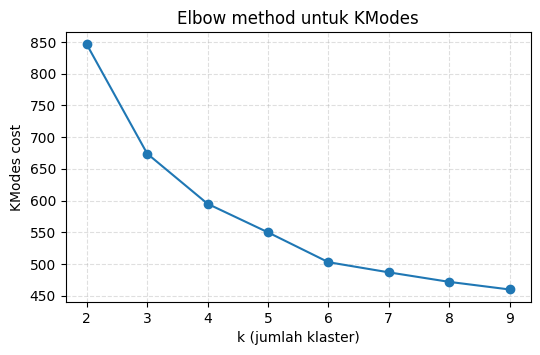

find_k_elbow_kmodes -> selesai.
  - ks tested: [2, 3, 4, 5, 6, 7, 8, 9]
  - costs: [846. 674. 595. 550. 503. 487. 472. 460.]
Pipeline -> rekomendasi k_best (heuristik delta) = 3
train_kmodes -> selesai.
  - init         : random
  - n_init       : 10
  - k clusters   : 6
  - cost (km.cost_): 503.0
  - ukuran klaster: [38 32 27 28 40 35]
simple_matching_distance_matrix -> selesai. ukuran matrix: (200, 200)
dunn_index_categorical -> selesai. Dunn = 0.1111111111111111
Ukuran klaster (counts):
cluster
0    38
1    32
2    27
3    28
4    40
5    35
Name: count, dtype: int64

Proporsi klaster:
cluster
0    19.0%
1    16.0%
2    13.5%
3    14.0%
4    20.0%
5    17.5%
Name: proportion, dtype: object

Karakteristik (mode) tiap klaster:

== Klaster 0 (n=38) ==
  - Age: High (35), Low (3)
  - Gender: Male (34), Female (4)
  - Academic_Level: Graduate (35), Undergraduate (3)
  - Country: Canada (9), Turkey (8), Pakistan (4)
  - Avg_Daily_Usage_Hours: Medium (27), High (6), Low (5)
  - Most_Used_P

In [41]:

df = df_students.copy()

# 1) Preprocess
drop_cols = []
for c in ['id', 'ID', 'index', 'Index', 'nama', 'name']:
    if c in df.columns:
        drop_cols.append(c)
df_cat, df_enc, enc = preprocess_to_categorical(df, drop_cols=drop_cols, fillna='NA', convert_all_str=True)

# 2) Cari k (elbow)
elbow_res = find_k_elbow_kmodes(df_enc, k_min=2, k_max=9, init='random', n_init=10, random_state=42, plot=True)

# 3) Pilih k_best otomatis sederhana (heuristik delta) -- kamu bisa ubah manual
costs = np.array(elbow_res['costs'])
if len(costs) >= 2:
    diffs = -np.diff(costs)  # positive jika turun
    k_best_idx = np.argmax(diffs) + 1  # +1 karena diff offset
    k_best = elbow_res['ks'][k_best_idx]
else:
    k_best = elbow_res['ks'][0]

print(f"Pipeline -> rekomendasi k_best (heuristik delta) = {k_best}")

# 4) Latih final dan dapatkan labels
km_model, labels = train_kmodes(df_enc, k=6, init='random', n_init=10, random_state=42)

# 5) Evaluasi Dunn
dunn = dunn_index_categorical(df_cat.values, labels)

# 6) Report
df_with_cluster = cluster_report(df, df_cat, labels)

# 7) Simpan semua hasil ke dict 'results_single'
results_single = {
    'df_cat': df_cat,
    'df_enc': df_enc,
    'enc': enc,
    'elbow': elbow_res,
    'k_best': k_best,
    'model': km_model,
    'labels': labels,
    'dunn': dunn,
    'df_with_cluster': df_with_cluster
}
print("\nPipeline selesai. Semua hasil tersimpan di variabel `results_single`.")


In [42]:
# ======================================================
# Cell Final - Ambil centroids / modes dan tampilkan hasil
# ======================================================
import numpy as np
import pandas as pd

# Asumsi results_single sudah berisi model & labels dari pipeline sebelumnya,
# atau km_model & labels masih di scope. Jika tidak, pastikan jalankan pipeline dulu.
# Contoh: km_model, labels = results_single['model'], results_single['labels']

# ---------- 1) Ambil objek km_model dan labels ----------
try:
    km_model = results_single.get('model', km_model)  # fallback ke variable km_model
    labels   = results_single.get('labels', labels)
except Exception:
    # jika results_single belum dibuat, asumsikan km_model dan labels ada
    pass

# ---------- 2) Ambil raw_centroids dengan pengecekan aman ----------
raw_centroids = None
if hasattr(km_model, 'cluster_centroids_'):
    raw_centroids = km_model.cluster_centroids_
    
elif hasattr(km_model, 'modes_'):
    raw_centroids = km_model.modes_
    

# pastikan jadi numpy array bila ada
if raw_centroids is not None:
    raw_centroids = np.asarray(raw_centroids)
    

# ---------- 3) Coba decode centroids (jika encoded) ----------
centroids_df_encoded = None
centroids_df_decoded = None
enc = results_single.get('enc', None)  # encoder object jika tersedia
df_cat = results_single.get('df_cat', None)  # original categorical dataframe

if raw_centroids is not None:
    try:
        centroids_df_encoded = pd.DataFrame(raw_centroids, columns=df_cat.columns)
    except Exception as e:
        # fallback: create DataFrame from rows if shape mismatch
        try:
            centroids_df_encoded = pd.DataFrame([list(r) for r in raw_centroids], columns=df_cat.columns)
        except Exception as e2:
            print("ERROR: gagal buat centroids_df_encoded:", e2)
            centroids_df_encoded = None

    # Strategy A: inverse_transform if encoder supports it
    if centroids_df_encoded is not None and enc is not None:
        try:
            if hasattr(enc, 'inverse_transform'):
                decoded = enc.inverse_transform(centroids_df_encoded)
                centroids_df_decoded = pd.DataFrame(decoded, columns=df_cat.columns)
                
        except Exception as e:
            print("WARN: enc.inverse_transform failed:", e)
            centroids_df_decoded = None


# ---------- 5) Tampilkan hasil rapi ----------
print("\n--- Centroids (encoded) ---")
display(centroids_df_encoded if centroids_df_encoded is not None else "Tidak tersedia")

print("\n--- Centroids (decoded, if available) ---")
display(centroids_df_decoded if centroids_df_decoded is not None else "Tidak tersedia / decode gagal")


# ---------- 6) Simpan kembali ke results_single ----------
results_single['raw_centroids'] = raw_centroids
results_single['centroids_df_encoded'] = centroids_df_encoded
results_single['centroids_df_decoded'] = centroids_df_decoded


--- Centroids (encoded) ---


,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
0,0,1,0,8,2,1,1,2,2,0,0
1,2,0,2,3,1,1,0,0,0,2,1
2,2,0,2,35,2,6,1,1,2,0,0
3,0,1,0,32,0,6,1,1,1,0,0
4,0,1,0,18,1,0,0,0,0,2,1
5,1,0,2,58,0,1,1,1,1,0,0



--- Centroids (decoded, if available) ---


,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
0,High,Male,Graduate,Canada,Medium,Instagram,Yes,Medium,Medium,High,High
1,Medium,Female,Undergraduate,Australia,Low,Instagram,No,High,High,Medium,Low
2,Medium,Female,Undergraduate,Nepal,Medium,TikTok,Yes,Low,Medium,High,High
3,High,Male,Graduate,Mexico,High,TikTok,Yes,Low,Low,High,High
4,High,Male,Graduate,Germany,Low,Facebook,No,High,High,Medium,Low
5,Low,Female,Undergraduate,USA,High,Instagram,Yes,Low,Low,High,High


In [38]:
import numpy as np

dissimilarities = []
for i, label in enumerate(labels):
    centroid = km_model.cluster_centroids_[label]
    diff = np.sum(df_enc.iloc[i].values != centroid)
    dissimilarities.append(diff)

df_with_cluster['dissimilarity'] = dissimilarities


In [39]:
avg_diss = df_with_cluster.groupby('cluster')['dissimilarity'].mean()
counts = df_with_cluster['cluster'].value_counts()

avg_diss_df = pd.DataFrame({
    'avg_dissimilarity': avg_diss,
    'counts': counts
})
print(avg_diss_df)


         avg_dissimilarity  counts
cluster                           
0                 2.666667      45
1                 2.733333      30
2                 3.354839      62
3                 2.936508      63


In [40]:
import pandas as pd
import numpy as np
from kmodes.util.dissim import matching_dissim

# Hitung dissimilarity per sampel ke centroid klasternya
diss = matching_dissim(df_enc.to_numpy(), km_model.cluster_centroids_[labels])

df_with_cluster = df_enc.copy()
df_with_cluster["cluster"] = labels
df_with_cluster["dissim"] = diss

# Hitung avg dissimilarity per cluster + jumlah anggotanya
cluster_stats = df_with_cluster.groupby("cluster").agg(
    avg_dissimilarity=("dissim", "mean"),
    counts=("dissim", "size")
)

# Hitung bobot masing-masing cluster
total_data = len(df_enc)
cluster_stats["weights"] = cluster_stats["counts"] / total_data

# Hitung weighted avg model dissimilarity (1 nilai untuk banding antar model)
weighted_avg_model_dissim = (cluster_stats["avg_dissimilarity"] * cluster_stats["weights"]).sum()

print("📌 Weighted Average Model Dissimilarity:", weighted_avg_model_dissim)
print("\n📊 Cluster Stats:")
display(cluster_stats)


📌 Weighted Average Model Dissimilarity: 2.9749999999999996

📊 Cluster Stats:


,avg_dissimilarity,counts,weights
cluster,,,
0,2.666667,45,0.225
1,2.733333,30,0.150
2,3.354839,62,0.310
3,2.936508,63,0.315
